#### Decision tree for regression in plain Python
A decision tree is a supervised machine learning model that can be used both for classification and regression. At its core, a decision tree uses a tree structure to predict an output value for a given input example. In the tree, each path from the root node to a leaf node represents a decision path that ends in a predicted value.

A simple example might predict housing prices:

caption

Decision trees have many advantages. For example, they are easy to understand and their decisions are easy to interpret. Also, they don't require a lot of data preparation. A more extensive list of their advantages and disadvantages can be found here.

CART training algorithm
In order to train a decision tree, various algorithms can be used. In this notebook we will focus on the CART algorithm (Classification and Regression Trees) for regression. The CART algorithm builds a binary tree in which every non-leaf node has exactly two children (corresponding to a yes/no answer).

Given a set of training examples and their labels, the algorithm repeatedly splits the training examples $D$ into two subsets $D_{left}, D_{right}$ using some feature $f$ and feature threshold $t_f$ such that samples with the same label are grouped together. At each node, the algorithm selects the split $\theta = (f, t_f)$ that produces the smallest mean squared error (MSE) (alternatively, we could use the mean absolute error).

So at each step, the algorithm selects the parameters $\theta$ that minimize the following cost function:

$$
J(D, \theta) = \frac{n_{left}}{n_{total}} MSE_{left} + \frac{n_{right}}{n_{total}} MSE_{right}
$$
$D$: remaining training examples
$n_{total}$ : number of remaining training examples
$\theta = (f, t_f)$: feature and feature threshold
$n_{left}/n_{right}$: number of samples in the left/right subset
$MSE_{left}/MSE_{right}$: MSE of the left/right subset
This step is repeated recursively until the maximum allowable depth is reached or the current number of samples $n_{total}$ drops below some minimum number. The original equations can be found here.

After building the tree, new examples can be classified by navigating through the tree, testing at each node the corresponding feature until a leaf node/prediction is reached.

Mean Squared Error (MSE)
When performing regression (i.e. the target values are continuous) we can evaluate a split using its MSE. The MSE of node $m$ is computed as follows:

$$
\hat{y}_m = \frac{1}{n_{m}} \sum_{i \in D_m} y_i
$$$$
MSE_m = \frac{1}{n_{m}} \sum_{i \in D_m} (y_i - \hat{y}_m)^2
$$
$D_m$: training examples in node $m$
$n_{m}$ : total number of training examples in node $m$
$y_i$: target value of $i-$th example
Caveats
Without regularization, decision trees are likely to overfit the training examples. This can be prevented using techniques like pruning or by providing a maximum allowed tree depth and/or a minimum number of samples required to split a node further.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.random.seed(123)

% matplotlib inline

#### dataset

Text(0,0.5,'Target values')

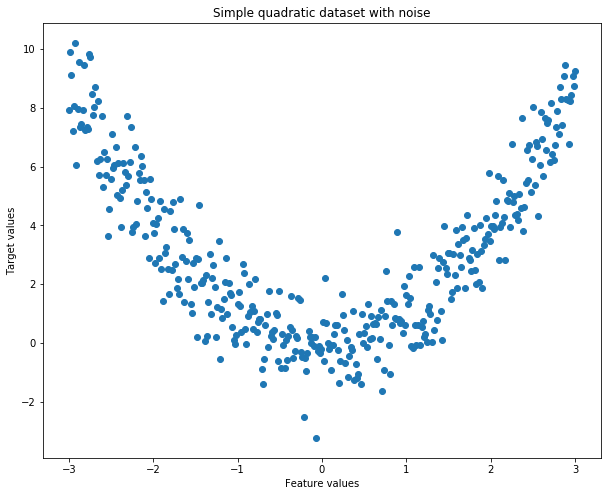

In [5]:
X = np.linspace(-3, 3, 400)
y = X ** 2 + np.random.randn(400)

plt.figure(figsize=(10,8))
plt.scatter(X, y)
plt.title("Simple quadratic dataset with noise")
plt.xlabel("Feature values")
plt.ylabel("Target values")

In [9]:
X = X[:, np.newaxis]

# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (300, 1)
Shape y_train: (300,)
Shape X_test: (100, 1)
Shape y_test: (100,)


#### Decision tree class

In [6]:
class DecisionTree:
    """
    Decision tree for regression
    """

    def __init__(self):
        self.root_dict = None
        self.tree_dict = None

    def split_dataset(self, X, y, feature_idx, threshold):
        """
        Splits dataset X into two subsets, according to a given feature
        and feature threshold.

        Args:
            X: 2D numpy array with data samples
            y: 1D numpy array with labels
            feature_idx: int, index of feature used for splitting the data
            threshold: float, threshold used for splitting the data

        Returns:
            splits: dict containing the left and right subsets
            and their labels
        """

        left_idx = np.where(X[:, feature_idx] < threshold)
        right_idx = np.where(X[:, feature_idx] >= threshold)

        left_subset = X[left_idx]
        y_left = y[left_idx]

        right_subset = X[right_idx]
        y_right = y[right_idx]

        splits = {
        'left': left_subset,
        'y_left': y_left,
        'right': right_subset,
        'y_right': y_right,
        }

        return splits

    def mean_squared_error(self, y_left, y_right, n_left, n_right):
        """
        Computes MSE of a split.

        Args:
            y_left, y_right: target values of samples in left/right subset
            n_left, n_right: number of samples in left/right subset

        Returns:
            mse_left: float, MSE of left subset
            mse_right: gloat, MSE of right subset
        """

        mse_left, mse_right = 0, 0

        if len(y_left) != 0:
            y_hat_left = (1 / n_left) * np.sum(y_left)
            mse_left = (1 / n_left) * np.sum((y_left - y_hat_left) ** 2)

        if len(y_right) != 0:
            y_hat_right = (1 / n_right) * np.sum(y_right)
            mse_right = (1 / n_right) * np.sum((y_right - y_hat_right) ** 2)

        return mse_left, mse_right

    def get_cost(self, splits):
        """
        Computes cost of a split given the MSE of the left
        and right subset and the sizes of the subsets.

        Args:
            splits: dict, containing params of current split
        """
        y_left = splits['y_left']
        y_right = splits['y_right']

        n_left = len(y_left)
        n_right = len(y_right)
        n_total = n_left + n_right

        mse_left, mse_right = self.mean_squared_error(y_left, y_right, n_left, n_right)
        cost = (n_left / n_total) * mse_left + (n_right / n_total) * mse_right

        return cost

    def find_best_split(self, X, y):
        """
        Finds the best feature and feature index to split dataset X into
        two groups. Checks every value of every attribute as a candidate
        split.

        Args:
            X: 2D numpy array with data samples
            y: 1D numpy array with labels

        Returns:
            best_split_params: dict, containing parameters of the best split
        """

        n_samples, n_features = X.shape
        best_feature_idx, best_threshold, best_cost, best_splits = np.inf, np.inf, np.inf, None

        for feature_idx in range(n_features):
            for i in range(n_samples):
                current_sample = X[i]
                threshold = current_sample[feature_idx]
                splits = self.split_dataset(X, y, feature_idx, threshold)
                cost = self.get_cost(splits)

                if cost < best_cost:
                    best_feature_idx = feature_idx
                    best_threshold = threshold
                    best_cost = cost
                    best_splits = splits

        best_split_params = {
            'feature_idx': best_feature_idx,
            'threshold': best_threshold,
            'cost': best_cost,
            'left': best_splits['left'],
            'y_left': best_splits['y_left'],
            'right': best_splits['right'],
            'y_right': best_splits['y_right'],
        }

        return best_split_params


    def build_tree(self, node_dict, depth, max_depth, min_samples):
        """
        Builds the decision tree in a recursive fashion.

        Args:
            node_dict: dict, representing the current node
            depth: int, depth of current node in the tree
            max_depth: int, maximum allowed tree depth
            min_samples: int, minimum number of samples needed to split a node further

        Returns:
            node_dict: dict, representing the full subtree originating from current node
        """
        left_samples = node_dict['left']
        right_samples = node_dict['right']
        y_left_samples = node_dict['y_left']
        y_right_samples = node_dict['y_right']

        if len(y_left_samples) == 0 or len(y_right_samples) == 0:
            node_dict["left_child"] = node_dict["right_child"] = self.create_terminal_node(np.append(y_left_samples, y_right_samples))
            return None

        if depth >= max_depth:
            node_dict["left_child"] = self.create_terminal_node(y_left_samples)
            node_dict["right_child"] = self.create_terminal_node(y_right_samples)
            return None

        if len(right_samples) < min_samples:
            node_dict["right_child"] = self.create_terminal_node(y_right_samples)
        else:
            node_dict["right_child"] = self.find_best_split(right_samples, y_right_samples)
            self.build_tree(node_dict["right_child"], depth+1, max_depth, min_samples)

        if len(left_samples) < min_samples:
            node_dict["left_child"] = self.create_terminal_node(y_left_samples)
        else:
            node_dict["left_child"] = self.find_best_split(left_samples, y_left_samples)
            self.build_tree(node_dict["left_child"], depth+1, max_depth, min_samples)

        return node_dict

    def create_terminal_node(self, y):
        """
        Creates a terminal node.

        Args:
            y: 1D numpy array with target values
        Returns:
            predicted_value: float, predicted value
        """
        return np.mean(y)

    def train(self, X, y, max_depth, min_samples):
        """
        Fits decision tree on a given dataset.

        Args:
            X: 2D numpy array with data samples
            y: 1D numpy array with labels
            max_depth: int, maximum allowed tree depth
            min_samples: int, minimum number of samples needed to split a node further
        """
        self.n_classes = len(set(y))
        self.root_dict = self.find_best_split(X, y)
        self.tree_dict = self.build_tree(self.root_dict, 1, max_depth, min_samples)

    def predict(self, X, node):
        """
        Predicts the class for a given input example X.

        Args:
            X: 1D numpy array, input example
            node: dict, representing trained decision tree

        Returns:
            prediction: float, predicted value
        """
        feature_idx = node['feature_idx']
        threshold = node['threshold']

        if X[feature_idx] < threshold:
            if isinstance(node['left_child'], (float)):
                return node['left_child']
            else:
                prediction = self.predict(X, node['left_child'])
        elif X[feature_idx] >= threshold:
            if isinstance(node['right_child'], (float)):
                return node['right_child']
            else:
                prediction = self.predict(X, node['right_child'])

        return prediction

#### Initializing and training the decision tree

In [10]:
tree = DecisionTree()
tree.train(X_train, y_train, max_depth=2, min_samples=2)

#### Printing the decision tree structure

In [11]:
def print_tree(node, depth=0):
    if isinstance(node, (float)):
        print(f"{depth * '  '}predicted class: {round(node, 3)}")
    else:
        print(f"{depth * '  '} feature {node['feature_idx']} < {round(node['threshold'], 3)}, "
             f"cost of split: {round(node['cost'], 3)}")
        print_tree(node["left_child"], depth+1)
        print_tree(node["right_child"], depth+1)

In [12]:
print_tree(tree.tree_dict)

 feature 0 < -2.053, cost of split: 5.829
   feature 0 < -2.639, cost of split: 1.105
    predicted class: 8.152
    predicted class: 5.674
   feature 0 < 1.947, cost of split: 2.45
    predicted class: 1.309
    predicted class: 6.105


#### Testing the decision tree

In [13]:
mse = 0
predictions = []
for i in range(X_test.shape[0]):
    result = tree.predict(X_test[i], tree.tree_dict)
    mse += (y_test[i] - result) ** 2
    predictions.append(result)


mse = (1 / len(y_test)) * mse
print(f"MSE on test set: {round(mse, 3)}")

MSE on test set: 2.464


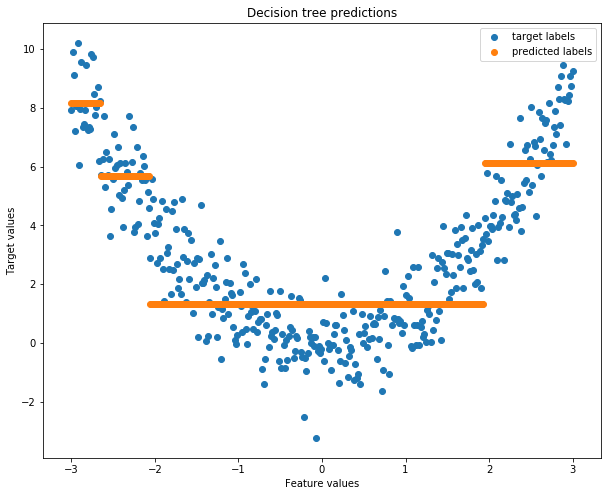

In [14]:
predictions = []
for i in range(X.shape[0]):
    result = tree.predict(X[i], tree.tree_dict)
    predictions.append(result)

plt.figure(figsize=(10, 8))
plt.title("Decision tree predictions")
plt.xlabel("Feature values")
plt.ylabel("Target values")
plt.scatter(X, y, label="target labels")
plt.scatter(X, predictions, label="predicted labels")
plt.legend(loc='upper right')
plt.show()